# Credit Scoring prediction

## Libraries loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import (LogisticRegressionCV,
                                  SGDClassifier)
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (f1_score, precision_score, recall_score, confusion_matrix,
                            accuracy_score, roc_auc_score, roc_curve, classification_report,
                            ConfusionMatrixDisplay, RocCurveDisplay, get_scorer_names)

from sklearn.model_selection import (train_test_split,
                                     StratifiedKFold,
                                     cross_val_score,
                                     learning_curve)

from scipy.stats import (pointbiserialr, chi2_contingency)

from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

import shap

import warnings

import random

warnings.filterwarnings(action = 'ignore')
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',100)
random.seed(123)

## data loading

In [2]:
#description type de variables
dictionnaire = {'age':'Age',
                'job':'Type of job, ex: entrepreneur',
                'marital':'Marital status, ex: divorced',
                'education':'education level, ex: high-school',
                'default':'Has credit in default? yes or no',
                'balance':'average yearly balance, ex: 24,000 USD',
                'housing':'has housing loan? yes or no',
                'loan':'has personal loan? yes or no',
                'contact':'cellular or telephone',
                'day':'last contact day of the month',
                'month':'last contact month of the year',
                'duration':'last contact duration in seconds',
                'campaign':'number of contacts performed during this campaign and for this client (numeric, includes last contact)',
                'pdays':'number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)',
                'previous':'number of contacts performed before this campaign and for this client (numeric)',
                'poutcome':'outcome of the previous marketing campaign (categorical: unknown, other,failure,success)',
                'y':'has the client subscribed a term deposit? (binary: yes or no)'
                }


def info(data):

    Information = pd.DataFrame({
        'Variables': data.columns,
        'Type': data.dtypes,
        'Unique_values': data.nunique(),
        'NA_counts': data.isna().sum(),
        'NA_percent%':data.isna().mean().round(4)*100,
        }).reset_index(drop=True)

    Information['Description_des_variables'] = Information['Variables'].map(dictionnaire)
    
    return Information

In [3]:
data = pd.read_csv('data/bank.csv', sep=';')

## fonction pour caster les variables de type <object>

In [4]:


def conversion(var):

    # conversion des variables type = <objet>
    if (var.dtype == 'object'):
        try:
            
            # conversion en string
            if var.nunique() > 12:
                return var.astype(str)
            
            # conversion en catégorie 
            else:
                return var.astype('category')
        
        except ValueError:
            
            return var
    
    else:
        return var 


In [5]:
data = data.apply(conversion)

In [6]:
info(data)

,Variables,Type,Unique_values,NA_counts,NA_percent%,Description_des_variables
0,age,int64,67,0,0.0,Age
1,job,category,12,0,0.0,"Type of job, ex: entrepreneur"
2,marital,category,3,0,0.0,"Marital status, ex: divorced"
3,education,category,4,0,0.0,"education level, ex: high-school"
4,default,category,2,0,0.0,Has credit in default? yes or no
5,balance,int64,2353,0,0.0,"average yearly balance, ex: 24,000 USD"
6,housing,category,2,0,0.0,has housing loan? yes or no
7,loan,category,2,0,0.0,has personal loan? yes or no
8,contact,category,3,0,0.0,cellular or telephone
9,day,int64,31,0,0.0,last contact day of the month


- Lister les variables catégorielles et les variables numériques

In [7]:
#Renommer la variable y
data.rename(columns={"y": "credit_subscribed"}, inplace=True)

# liste variables numériques
numvars = data.select_dtypes(exclude=['category']).columns.tolist()

#liste variables catégorielles
catvars = data.select_dtypes(include=['category']).columns.tolist()

## Visualisation des données 

In [38]:

def category_distribution(data, var):
    # Validation des données
    if not isinstance(data, pd.DataFrame):
        raise TypeError('data is not a pandas.DataFrame')

    if var not in data.columns or data[var].dtype != 'category':
        raise TypeError(f'{var} not in data or not a <dtype.category>')
    
    # Calcul des fréquences et des pourcentages
    counts = data[var].value_counts()
    percentages = data[var].value_counts(normalize=True) * 100

    # Création du tableau
    distribution_table = pd.DataFrame({
        'Nombre d\'observations': counts,
        'Pourcentage (%)': percentages.round(2)
    })
        # Calcul des totaux
    total_counts = counts.sum()
    total_percentage = percentages.sum()

    # Ajout de la ligne des totaux
    distribution_table.loc['Total'] = [total_counts, total_percentage]
    
    print(f"Repartition des effectifs: {var}")
    
    return distribution_table


In [39]:
# repartition de la variable d'intérêt
category_distribution(data, 'credit_subscribed')

Repartition des effectifs: credit_subscribed


,Nombre d'observations,Pourcentage (%)
credit_subscribed,,
no,4000.0,88.48
yes,521.0,11.52
Total,4521.0,100.00


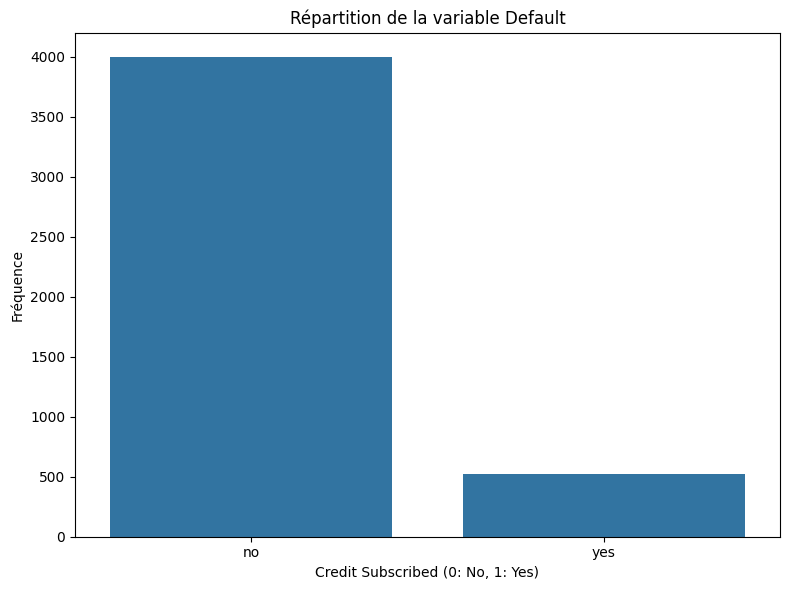

In [42]:
# Visualiser la répartition
plt.figure(figsize=(8, 6))
sns.countplot(x='credit_subscribed', data = data)
plt.title('Répartition de la variable Default')
plt.xlabel('Credit Subscribed (0: No, 1: Yes)')
plt.ylabel('Fréquence')

plt.tight_layout()
plt.show()

### Visualisations croisées entre la variable d'intérêt et les variables continues

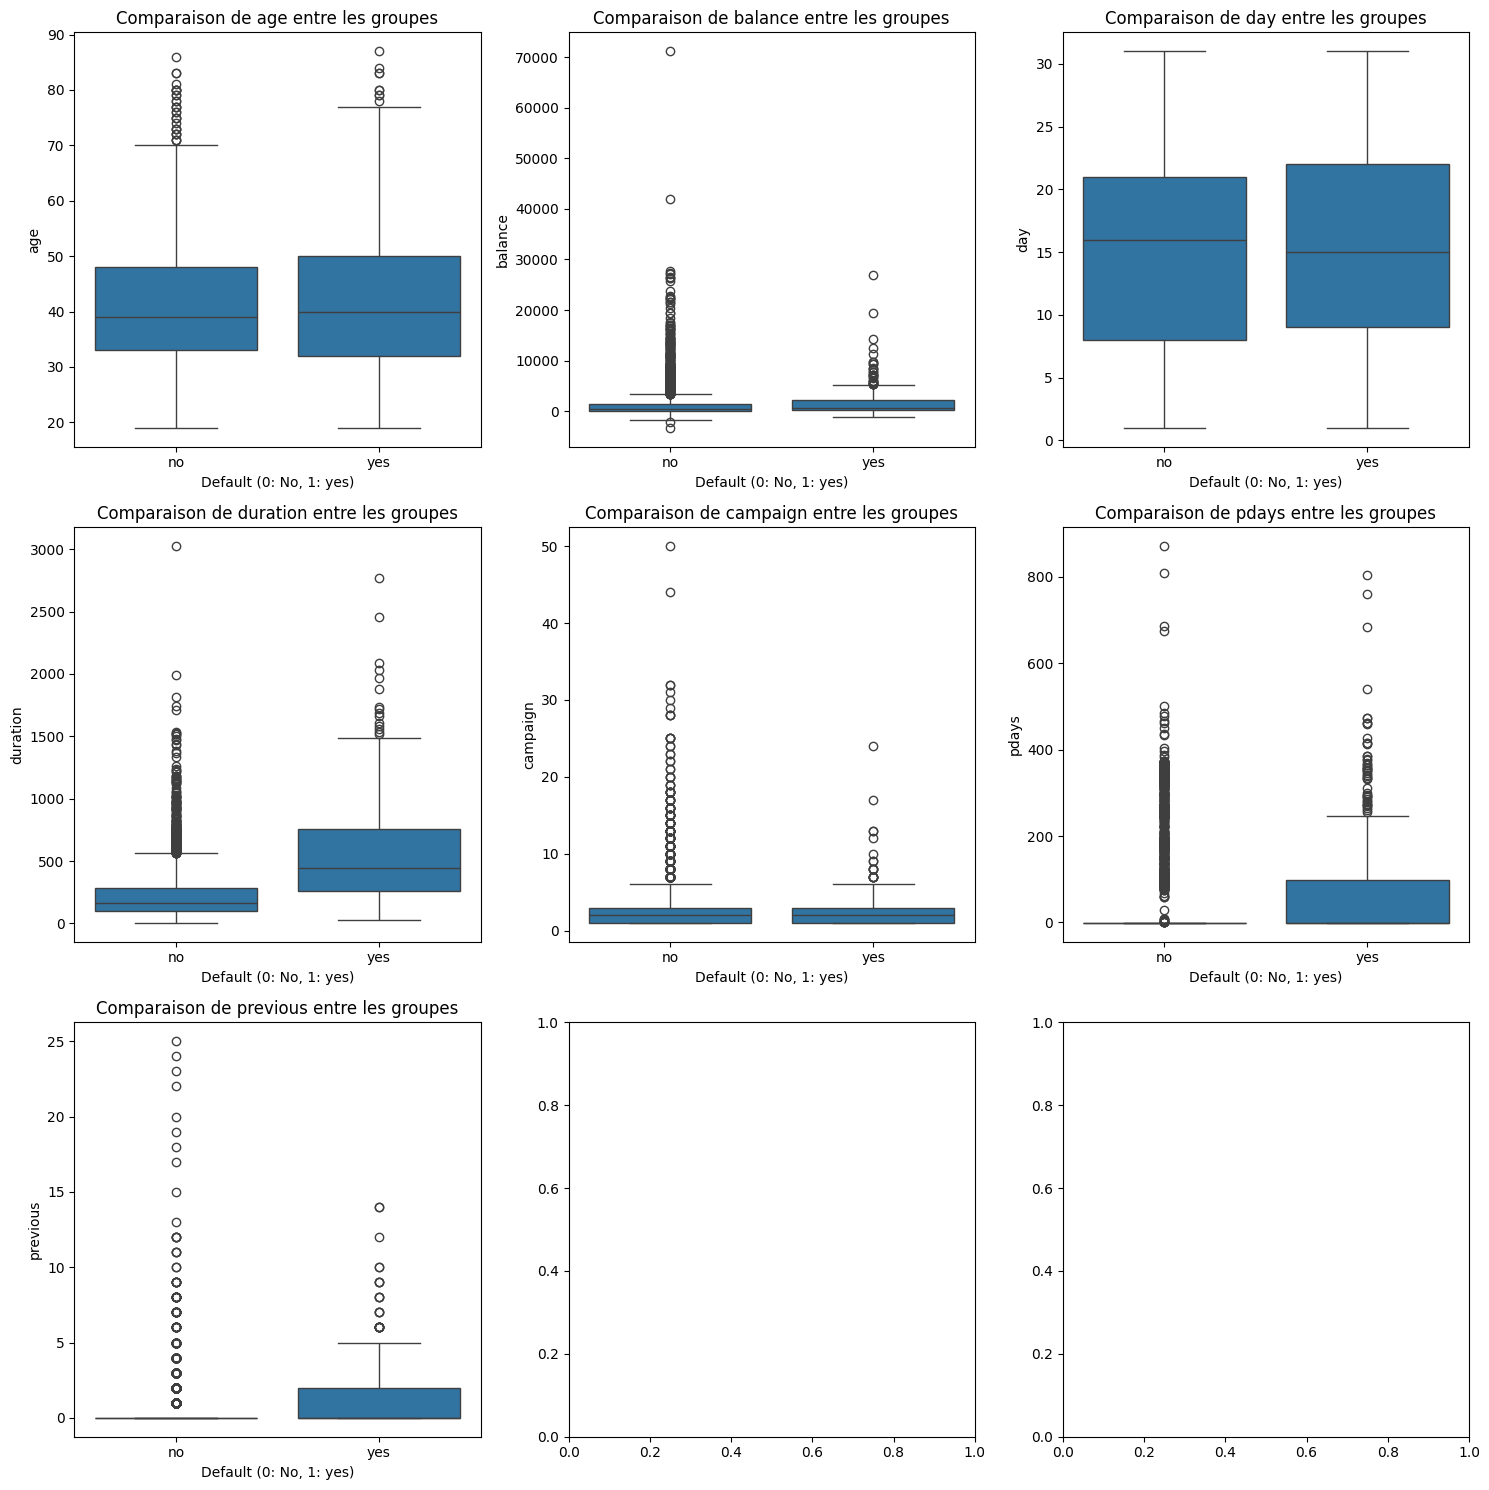

In [41]:
import math

# Calcul du nombre de lignes et de colonnes pour la grille
n_vars = len(numvars)
n_cols = 3
n_rows = math.ceil(n_vars / n_cols)

# Création de la grille de sous-graphiques
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows)) # Ajuster la taille si besoin

# Affichage des box plots dans les sous-graphiques
for i, variable in enumerate(numvars):
    row = i // n_cols
    col = i % n_cols
    sns.boxplot(x='credit_subscribed', y=variable, data=data, ax=axes[row, col])
    axes[row, col].set_title(f'Comparaison de {variable} entre les groupes')
    axes[row, col].set_xlabel('Default (0: No, 1: yes)')
    axes[row, col].set_ylabel(variable)

# Ajustement de l'espacement entre les sous-graphiques
plt.tight_layout()

# Affichage de la grille de sous-graphiques
plt.show()

In [43]:
catvars

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome',
 'credit_subscribed']

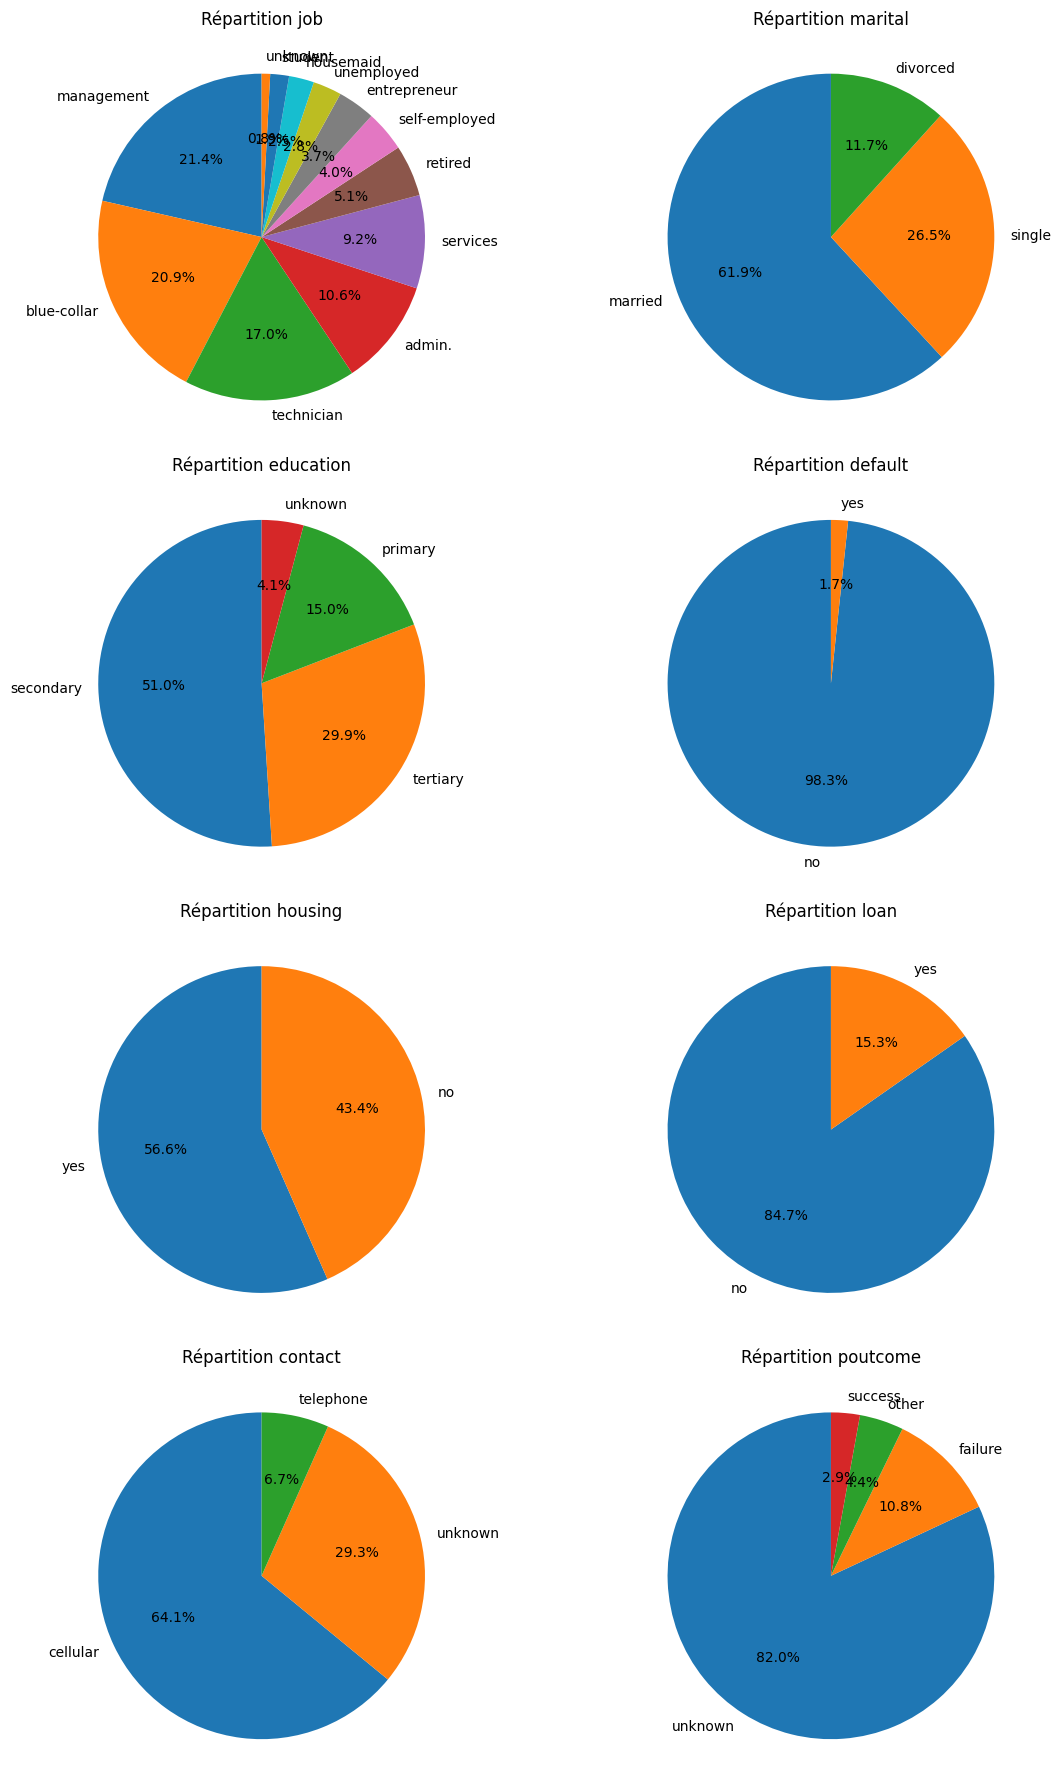

In [45]:
# Création de la figure avec 2 lignes et 6 colonnes
fig, axes = plt.subplots(4, 2, figsize=(12, 18))

# Liste des colonnes à afficher
columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
           'poutcome']

# Boucle pour créer les graphiques
for i, col in enumerate(columns):
    row = i // 2
    col_index = i % 2

    data[col].value_counts().plot.pie(ax=axes[row, col_index], autopct='%1.1f%%', startangle=90)
    axes[row, col_index].set_title(f"Répartition {col}")
    axes[row, col_index].set_ylabel("")


plt.tight_layout()
plt.show()

## Analyses Statistiques 

### Corrélation entre les variables

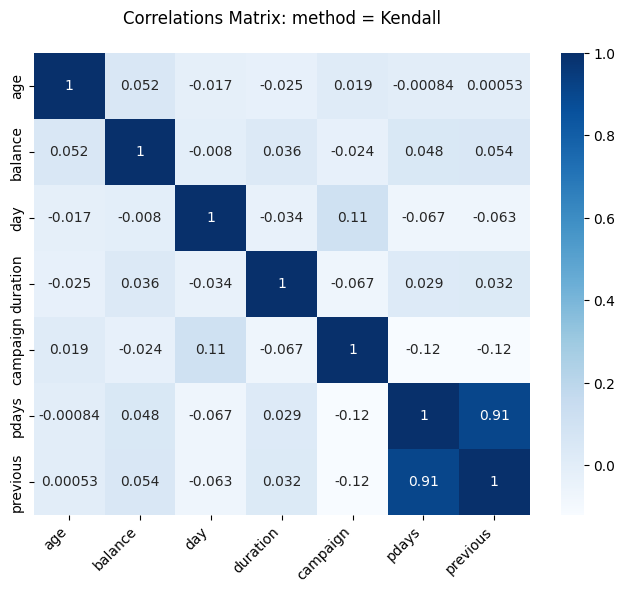

In [8]:
plt.figure(figsize=(8, 6))
sns.heatmap(data[numvars].corr(method='kendall'),
            cmap='Blues', annot=True)
plt.title('Correlations Matrix: method = Kendall\n')
plt.xticks(rotation=45, ha='right')
plt.show()

### Tableau statistiques croisés sur solde de crédit  

In [9]:
def cross_stat(data:pd.DataFrame, catlist:list, statvars:list):

    """--Docstring--
    fonction pour réaliser des statistiques
    sur des variables croisées.
    
    Args:
         data: le dataframe
         catlist: (list) variables catégorielles
         statvars: (list) variables continues
    
    return a dataframe
    """
    # initialisation d'un tableau vide
    table = pd.DataFrame()
    
    # Création de dictionnaire pour les indexes
    index_mapping = {value: cat for cat in catlist for value in data[cat].unique()}

    
    for var in statvars:

        for cat in catlist:
            
            X = data.groupby(by=cat)[var].agg(min = 'min',
                                              max = 'max',
                                              mean = 'mean',
                                              st_deviation = 'std',
                                              quartile1 = lambda x: x.quantile(0.25),
                                              median = 'median',
                                              quartile3 = lambda x: x.quantile(0.75),
                                              category_size = 'count')

            table = pd.concat([table,X], axis = 0, ignore_index = False)
    
        table.reset_index(names = 'valeurs', inplace = True)
        table['Categories'] = table['valeurs'].map(index_mapping)
        table.set_index(['Categories','valeurs'], inplace = True)
    
        print(f'Tableau Statistiques croisées sur: {var}')
        display(table.round(2))
        print('\n\n')


In [10]:
cross_stat(data, catvars, ['balance'])

Tableau Statistiques croisées sur: balance


min    max     mean  st_deviation  \
Categories        valeurs                                             
job               admin.         -967  22171  1226.74       2370.12   
                  blue-collar   -1400  16353  1085.16       2040.22   
                  entrepreneur  -2082  42045  1645.12       4441.30   
                  housemaid      -759  26965  2083.80       4603.84   
                  management    -1746  27359  1766.93       3267.73   
                  retired       -1206  71188  2319.19       5846.38   
                  self-employed -3313  16430  1392.41       2479.64   
                  services      -1202  26394  1103.96       2445.24   
                  student        -230  11555  1543.82       2579.89   
                  technician    -1680  27733  1331.00       2630.25   
                  unemployed     -872   9019  1089.42       1692.27   
poutcome          unknown           0   7337  1501.71       1957.26   
marital           divorced      -1148  26306  1122.39       2199.92   
                  married       -3313  71188  1463.20       3188.57   
                  single        -1313  27733  1460.41       2879.81   
education         primary        -966  71188  1411.54       3713.76   
                  secondary     -2082  26452  1196.81       2419.70   
                  tertiary      -3313  42045  1775.42       3460.62   
poutcome          unknown        -715  21244  1701.25       2981.38   
credit_subscribed no            -1746  71188  1450.55       3026.70   
                  yes           -3313   1238  -208.72        575.68   
                  no            -2082  71188  1595.28       3440.85   
                  yes           -3313  27733  1290.31       2624.64   
                  no            -1746  71188  1513.86       3121.23   
                  yes           -3313  27069   917.16       2229.89   
contact           cellular      -2082  71188  1423.20       3058.21   
                  telephone     -1400  26452  1806.04       3250.22   
poutcome          unknown       -3313  27733  1334.32       2836.18   
month             apr            -932  26965  1658.06       3045.67   
                  aug            -970  42045  1454.56       3152.32   
                  dec             389  14533  3567.15       4448.25   
                  feb            -970  26306  1319.04       2421.58   
                  jan            -735  16957   976.36       1911.02   
                  jul           -2082  26452   789.47       1980.83   
                  jun           -1746  27733  1884.79       3600.50   
                  mar               0   9676  2049.53       2584.93   
                  may           -3313  22546  1104.17       2346.05   
                  nov            -872  22196  2603.15       3514.00   
                  oct            -247  71188  2738.65       8369.52   
                  sep            -195  14220  1589.35       2773.45   
poutcome          failure       -1400  26306  1644.65       3252.29   
                  other          -247  15030  1424.47       2372.26   
                  success        -242  15459  1949.41       2894.43   
                  unknown       -3313  71188  1374.86       3008.52   
credit_subscribed no            -3313  71188  1403.21       3075.35   
                  yes           -1206  26965  1571.96       2444.40   

                                 quartile1  median  quartile3  category_size  
Categories        valeurs                                                     
job               admin.             62.25   430.0    1320.75            478  
                  blue-collar        61.00   408.5    1204.50            946  
                  entrepreneur       67.50   365.5    1428.75            168  
                  housemaid          24.25   296.5    1854.50            112  
                  management         99.00   577.0    1859.00            969  
                  retired           155.25   672.5    2478.75           

### Test d'associations du khi-deux entre les variables catégorielles et la variable cible 

In [11]:

def test_khi2(data, target, variables, alpha=0.05):
    """
    Calcule les tests du Chi2 entre une liste de variables catégorielles et une variable cible binaire.

    Parameters:
        data (pd.DataFrame): le DataFrame contenant les données
        target (str): nom de la variable cible (ex: "Default")
        variables (list): liste des variables catégorielles
        alpha (float): seuil de significativité (par défaut 0.05)

    Returns:
        pd.DataFrame: tableau récapitulatif des résultats
    """
    results = []

    for var in variables:
        contingency_table = pd.crosstab(data[var], data[target])
        chi2, p, dof, expected = chi2_contingency(contingency_table)

        decision = "Rejeter H0 (association)" if p < alpha else "Ne pas rejeter H0 (indépendance)"
        results.append({
            "Variable": var,
            "Chi2": chi2,
            "ddl": dof,
            "p-value": p,
            "Décision (alpha={})".format(alpha): decision
                        })

    return pd.DataFrame(results)



- Application du test

In [12]:
liste = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']

test_khi2(data, target = "credit_subscribed", variables = liste)

,Variable,Chi2,ddl,p-value,Décision (alpha=0.05)
0,job,68.988286,11,1.901391e-10,Rejeter H0 (association)
1,marital,19.030056,2,7.373535e-05,Rejeter H0 (association)
2,education,15.236580,3,1.625240e-03,Rejeter H0 (association)
3,default,0.000000,1,1.000000e+00,Ne pas rejeter H0 (indépendance)
4,housing,48.884628,1,2.714700e-12,Rejeter H0 (association)
5,loan,21.871822,1,2.914829e-06,Rejeter H0 (association)
6,contact,87.869857,2,8.304301e-20,Rejeter H0 (association)
7,poutcome,386.877387,3,1.539883e-83,Rejeter H0 (association)


### Test de corrélation Pearson entre la variable d'intérêt et les variables continues

In [29]:
def corr_pearson(data, target, variables, alpha=0.05):
    """
    Calcule la corrélation point-bisérial entre une variable binaire et plusieurs variables continues.

    Parameters:
        data (pd.DataFrame): DataFrame contenant les données
        target (str): nom de la variable binaire (ex: "Default")
        variables (list): liste des variables continues
        alpha (float): seuil de significativité (par défaut 0.05)

    Returns:
        pd.DataFrame: tableau récapitulatif avec corrélation, p-value et décision
    """
    results = []

  
    a, b = data[target].unique()
    y = data[target].map({a:0, b:1}).astype('float')

    for var in variables:
        x = data[var]

        # Calcul corrélation point-bisérial
        corr, pval = pointbiserialr(y, x)

        decision = "Rejeter H0 (association)" if pval < alpha else "Ne pas rejeter H0 (indépendance)"
        results.append({
            "Variable": var,
            "Corrélation (r_pb)": corr,
            "p-value": pval,
            "Décision (alpha={})".format(alpha): decision
        })

    return pd.DataFrame(results)


- Application du test de correlation

In [30]:
corr_pearson(data, target = "credit_subscribed", variables = numvars)

,Variable,Corrélation (r_pb),p-value,Décision (alpha=0.05)
0,age,0.045092,2.424536e-03,Rejeter H0 (association)
1,balance,0.017905,2.287158e-01,Ne pas rejeter H0 (indépendance)
2,day,-0.011244,4.497348e-01,Ne pas rejeter H0 (indépendance)
3,duration,0.401118,2.150445e-174,Rejeter H0 (association)
4,campaign,-0.061147,3.885794e-05,Rejeter H0 (association)
5,pdays,0.104087,2.287071e-12,Rejeter H0 (association)
6,previous,0.116714,3.477971e-15,Rejeter H0 (association)


## Modélisation du Score